# BIP Framework training example 

In [51]:
using Pkg
Pkg.activate("..")
using BIPs

  Activating project at `/z1-josemm/josemm/MyDocs/BIPs.jl`


In [52]:
using Statistics
using Pkg.Artifacts

Lets begin by bringing in the dataset. It contains tree splits:
* **train**: the training set with 1M jets
* **validation**: the validation set with 400k jets

And of course later we will use the **test** set with other 400k jets to report the results


In [53]:
dataset_path = "../../DataLake/raw"
# dataset_path = "/Users/ortner/datasets/toptagging"

train_data_path = dataset_path*"/train.h5"
val_data_path = dataset_path*"/val.h5"

"../../DataLake/raw/val.h5"

### Reading the data

In order to read the datasets, we call the `read_dataset` function:
to read the TopQuark format

In [54]:
train_jets, train_labels = BIPs.read_data("TQ", train_data_path)
train_labels = [reinterpret(Bool, b == 1.0) for b in train_labels]
print("Number of entries in the training data: ", length(train_jets))

InterruptException: InterruptException:

In [55]:
val_jets, val_labels = BIPs.read_data("TQ", val_data_path)
val_labels = [reinterpret(Bool, b == 1.0) for b in val_labels]
print("Number of entries in the validation data:", length(val_jets))

Number of entries in the validation data:402999

Lets examine how one of the jets looks like, each one of the entries is one detected particle's four momentum $(E, p_x, p_y, p_z)$.

However,in order to compute the embeddings, it is necesary to convert the jets to a format that can be used by the framework. The function `data2hyp` allows to convert each detected four momentum to the jet basis, a.k.a $(\tilde p_T, \cos(\theta), \sin(\theta), \tilde y, E_T)$

In [56]:
train_transf_jets = data2hyp(train_jets)
val_transf_jets = data2hyp(val_jets)
println("Transformed jets")

Transformed jets


### The embeddings

Once the jets are converted to the jet basis, it is moment to embed the model using the *Invariant Polynomials*. 

The function `build_ip` allocates efficiently the sparse basis, while the `bip_data` computes the invariant representation of each one of the jets.

In [57]:
f_bip, specs = build_ip(order=3, levels=7)
    
function bip_data(dataset_jets)
    storage = zeros(length(dataset_jets), length(specs))
    for i = 1:length(dataset_jets)
        storage[i, :] = f_bip(dataset_jets[i])
    end
    storage[:, 2:end]
end

bip_data (generic function with 1 method)

In [58]:
train_embedded_jets = bip_data(train_transf_jets)
println("Embedded train jets correclty")
val_embedded_jets = bip_data(val_transf_jets)
println("Embedded test jets correclty")

Embedded train jets correclty


Embedded test jets correclty


### Training a classifier model

The embeddings are now created for the dataset. From this point on, the classification itself is absolutelly versatile. For this specific example we will use the out-of-the box classifier `sklearn.linear_model.HistGradientBoostingClassifier` that bines the data and then applies a grandient boosted trees algorithm. 

Now, lets fit a simple model to the data.


In [59]:
using PyCall
@pyimport sklearn.ensemble as sk_ensemble

In [60]:
GCT = sk_ensemble.HistGradientBoostingClassifier(verbose=true).fit(train_embedded_jets, train_labels)

1 tree, 31 leaves, max depth = 16, train loss: 0.18761, val loss: 0.19189, in 0.315s
Fit 100 trees in 108.111 s, (3100 total leaves)
Time spent computing histograms: 31.302s
Time spent finding best splits:  1.052s
Time spent applying splits:      0.843s
Time spent predicting:           0.205s
Binning 5.188 GB of training data: 17.557 s
Binning 0.576 GB of validation data: 0.204 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.62469, val loss: 0.62486, in 0.173s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.56842, val loss: 0.56869, in 0.168s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.52149, val loss: 0.52184, in 0.167s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.48183, val loss: 0.48226, in 0.161s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.44818, val loss: 0.44873, in 0.163s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.41914, val loss: 0.41977, in 0.168s
[7/100] 1 tree, 31 leaves, ma

PyObject HistGradientBoostingClassifier(verbose=True)

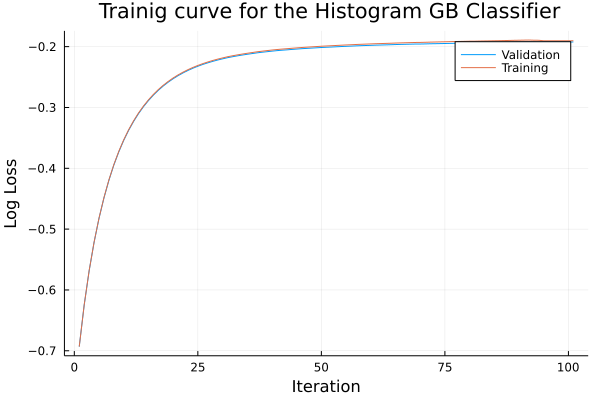

In [61]:
using Plots
Plots.plot(GCT[:validation_score_], label="Validation", xlabel="Iteration", ylabel="Log Loss")
Plots.plot!(GCT[:train_score_], label="Training", title=" Trainig curve for the Histogram GB Classifier")

# Lest test how we do performance

Now that we understanad the framework, lets see how our model performs on the test set.

In [62]:
test_data_path = "../../DataLake/raw/test.h5"

"../../DataLake/raw/test.h5"

In [63]:
test_jets, test_labels = BIPs.read_data("TQ", test_data_path)
test_labels = [reinterpret(Bool, b == 1.0) for b in test_labels]
test_transf_jets = data2hyp(test_jets)
test_embedded_jets = bip_data(test_transf_jets)
print("Embedded test jets correclty")

Embedded test jets correclty

In [64]:
test_preds = GCT.score(test_embedded_jets, test_labels)

0.9230093292771976

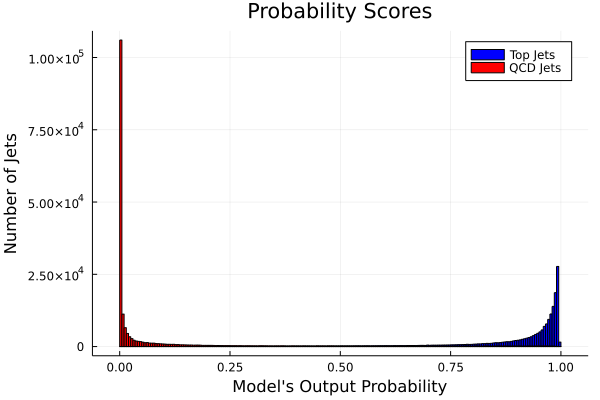

In [65]:
test_probas = GCT.predict_proba(test_embedded_jets)
bkg_index = [label==false for label in test_labels]
Plots.histogram(test_probas[:, 2][test_labels], color="Blue", label="Top Jets", xlabel="Model's Output Probability", ylabel="Number of Jets")
Plots.histogram!(test_probas[:, 2][bkg_index], color="Red", label="QCD Jets", title="Probability Scores")